Code for the figures, where an image is restored from a fraction of pixels (fig. 7 bottom, fig. 14 of supmat).

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from torch.autograd import Variable
from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor

# Choose figure

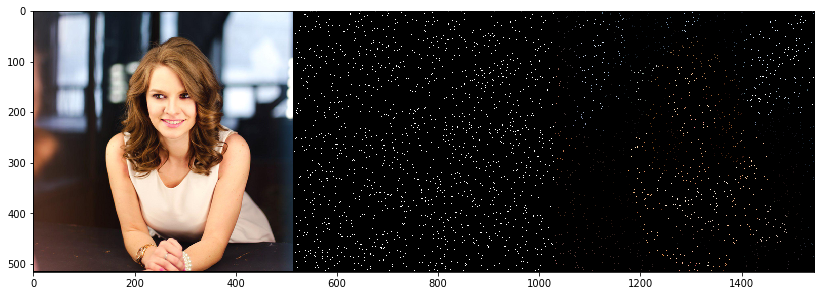

In [2]:
# fig. 7 (bottom)
# f = './data/restoration/barbara.png'

# fig. 14 of supmat
f = './data/restoration/kate.png'


img_pil, img_np = get_image(f, imsize)

if 'barbara' in f:
    img_np = nn.ReflectionPad2d(1)(np_to_var(img_np)).data[0].numpy()
    img_pil = np_to_pil(img_np)
    
    img_mask = get_bernoulli_mask(img_pil, 0.50)
    img_mask_np = pil_to_np(img_mask)
elif 'kate' in f:
    img_mask = get_bernoulli_mask(img_pil, 0.98)

    img_mask_np = pil_to_np(img_mask)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
else:
    assert False
    

img_masked = img_np*img_mask_np

mask_var = np_to_var(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Set up everything

In [3]:
show_every=100
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
LR = 0.01
if 'barbara' in f:
    OPT_OVER = 'net,input'
    num_restarts = 10
    num_iter = 300
    def get_new_net(): 
        return skip(input_depth, img_np.shape[0], num_channels_down = [4], 
                                                 num_channels_up   = [128],
                                                 num_channels_skip = [32], 
                                  filter_size_up = 5, filter_size_down = 5, upsample_mode='bilinear', filter_skip_size=7,
                                  need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif 'kate' in f:
    pad = 'reflection' # 'zero'
    OPT_OVER = 'net'
    num_restarts = 1
    num_iter = 1000
        
    def get_new_net(): 
        return skip(input_depth, img_np.shape[0], num_channels_down = [16, 32, 64, 128, 128],
                                             num_channels_up   = [16, 32, 64, 128, 128],
                           num_channels_skip =    [0, 0, 0, 0, 0],   
                           filter_size_down = 3, filter_size_up = 3, filter_skip_size=1,
                           upsample_mode='bilinear', 
                           downsample_mode='avg',
                           need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = np_to_var(img_np).type(dtype)

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()

In [4]:
def closure():
    global i

    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = var_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

# Main loop

========== 0
Starting optimization with ADAM


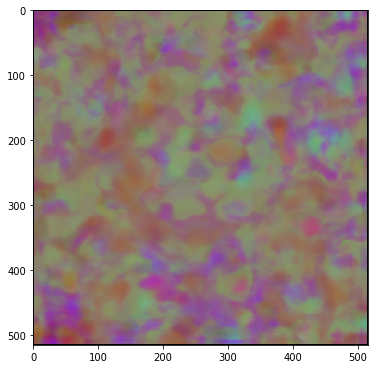

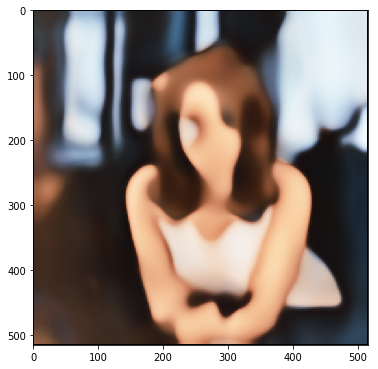

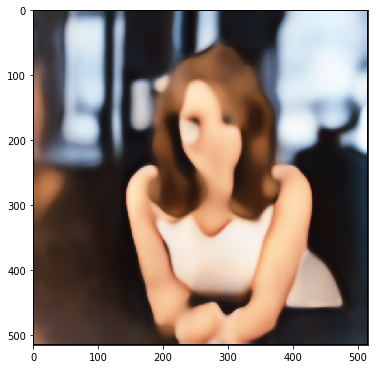

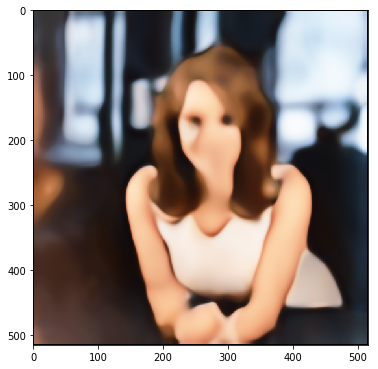

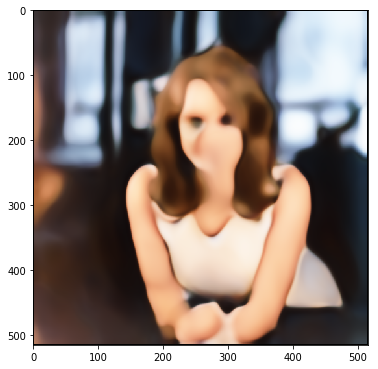

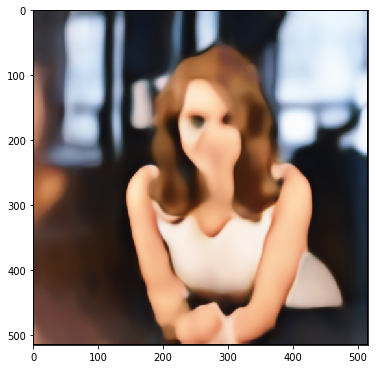

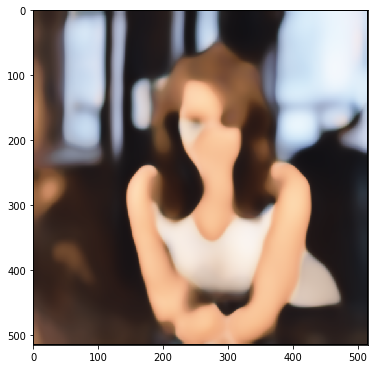

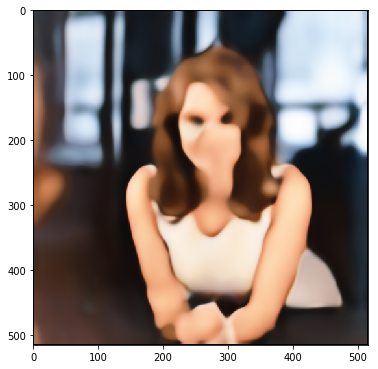

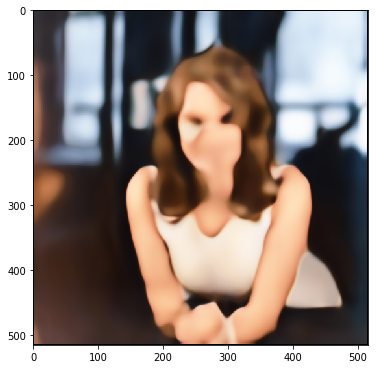

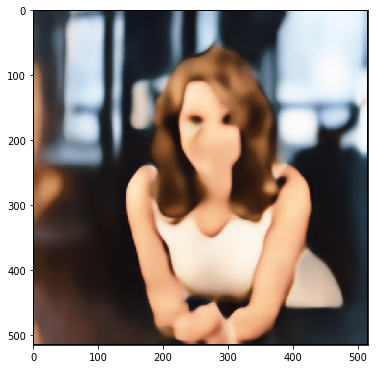

In [5]:
for restart in range(num_restarts):
    print('==========', restart)
    net = get_new_net()

    p = get_params(OPT_OVER, net, net_input)
    i=0
    optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

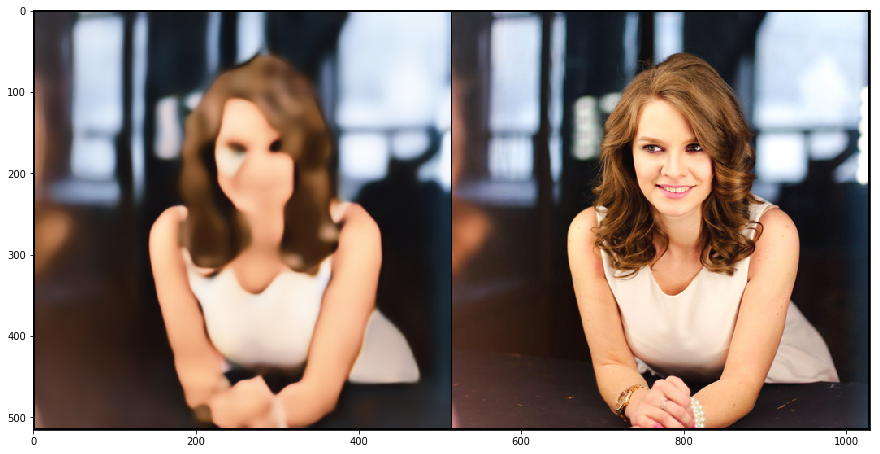

In [6]:
out_np = var_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);